In [578]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


from sklearn.compose import make_column_selector, make_column_transformer

In [579]:
heart_raw = pd.read_csv('heart.csv')
heart_raw

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


# Heart Disease Dataset
## 1. EDA and Preprocessing
### 1.1 Dataset Preparation

---
### **Description**


> \# marks the categorical data

- Age: age of the patient [years]
- #Sex: sex of the patient [M: Male, F: Female]
- #ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- #FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- #RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation     or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- #ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- #ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- #HeartDisease: output class [1: heart disease, 0: Normal]

---
**Problem 1** 

No duplicated row found in this data

There is no null datas as well.

But should treat #FastingBS and #HeartDisease as categorical than numeric.


In [580]:
heart_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [581]:
heart_raw[heart_raw.duplicated(keep='first')]
heart_raw_dropped = heart_raw.drop_duplicates()
heart_raw_dropped = heart_raw_dropped.astype({'FastingBS':'category','HeartDisease':'category'})

heart_raw_dropped

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


**Problem 2**

Drop Missing Values

Cholesterl will be done later.

One missing value found in RestingBP.

In [582]:
heart_raw_dropped = heart_raw_dropped.drop(heart_raw_dropped[heart_raw_dropped['RestingBP'] == 0].index)

### 1.2 Train Test Split

Get test test out of sight first.


However, male's portion in the data is dominent significantly. Considering about the already known difference of morbidity in different sex, we can do stratified sampling when spliting the test and train sets.

***For ease of plotting, onehot encode for categorical datas will be done after EDA part.***

---

In [583]:
predictor = heart_raw_dropped[heart_raw_dropped.columns.drop('HeartDisease')]
target = heart_raw_dropped['HeartDisease']

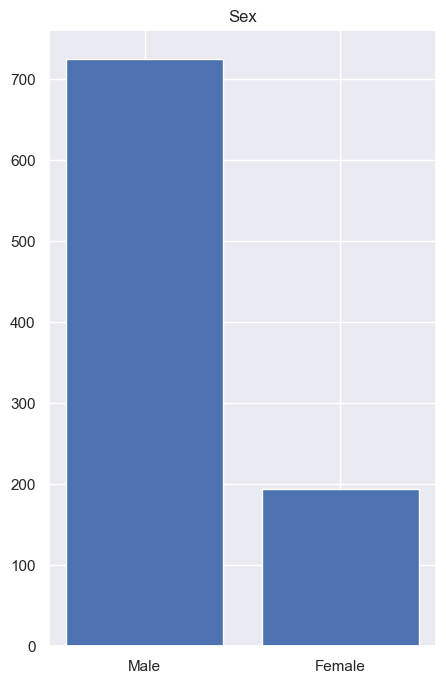

In [584]:
cat = ['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope']
numeric = ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']

plt.figure(figsize=(5, 8))
sex = pd.DataFrame(predictor['Sex'].astype('category'))
plt.title('Sex')
sexc = sex.value_counts()
plt.bar(list(['Male','Female']),sexc.tolist())

plt.show()

In [585]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(predictor,target,test_size=0.2,stratify=predictor['Sex'])

Check if it is correctly splited by sex:

In [586]:
print("Ratios:")
(Xtrain['Sex'].value_counts().iloc[1] / Xtrain['Sex'].value_counts().iloc[0] , predictor['Sex'].value_counts().iloc[1] / predictor['Sex'].value_counts().iloc[0])

Ratios:


(0.2659758203799655, 0.26657458563535913)

In [587]:
print("Ratios:")
(Xtest['Sex'].value_counts().iloc[1] / Xtest['Sex'].value_counts().iloc[0] , predictor['Sex'].value_counts().iloc[1] / predictor['Sex'].value_counts().iloc[0])

Ratios:


(0.2689655172413793, 0.26657458563535913)

### 1.3 EDA

---

Overall correlation check by heatmap

<Axes: >

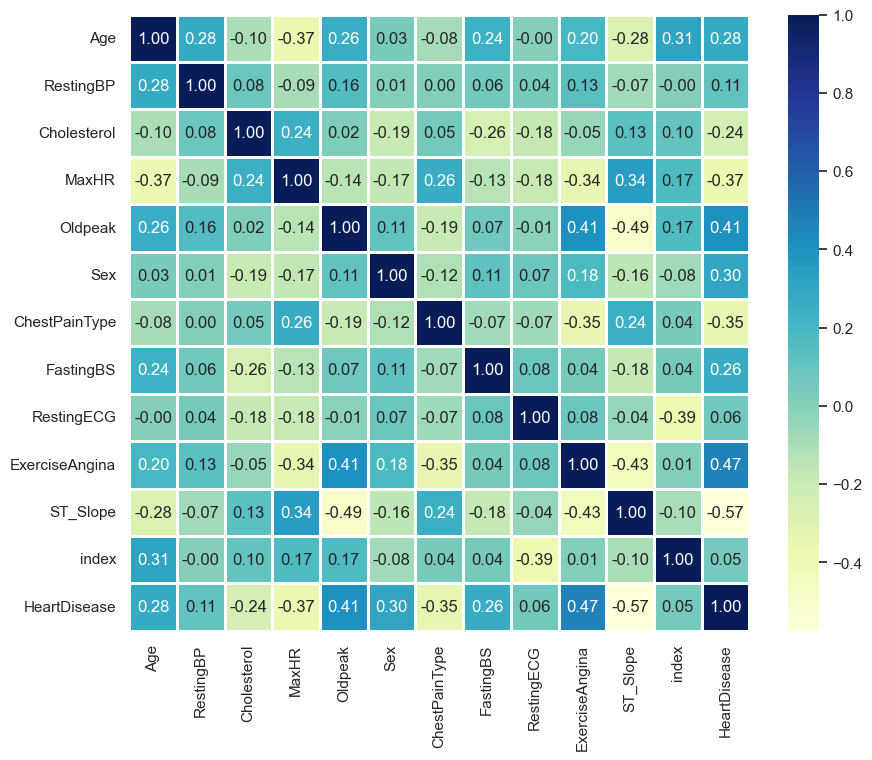

In [588]:
TrainData = heart_raw_dropped.loc[Xtrain.index]
TrainData.columns.tolist()

ordinalEncoder = OrdinalEncoder()
TrainData2 = TrainData.reset_index()
cat_encode = pd.DataFrame(ordinalEncoder.fit_transform(TrainData2[cat]))
cat_encode.columns = ordinalEncoder.get_feature_names_out()
cat_encode
encoded_raw = pd.concat([TrainData2[numeric],cat_encode,Ytrain.reset_index()],axis=1)

plt.figure(figsize=(10,8))
sb.heatmap(encoded_raw.corr(),annot=True,cmap='YlGnBu',fmt='.2f',linewidths=2)

**`Age`, `Oldpeak`, `MaxHR`, `ChestPainType`, `ExerciseAngina`, `ST_Slope` have great influence on result**

**`RestingBP`, `RestingECG` can be ignored.**

#### 1.3.1 Show relationship between Response and Categorical predictors

In [589]:
TrainData = heart_raw_dropped.loc[Xtrain.index]
TrainData.columns.tolist()

['Age',
 'Sex',
 'ChestPainType',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'RestingECG',
 'MaxHR',
 'ExerciseAngina',
 'Oldpeak',
 'ST_Slope',
 'HeartDisease']

A quick overview for all variables:

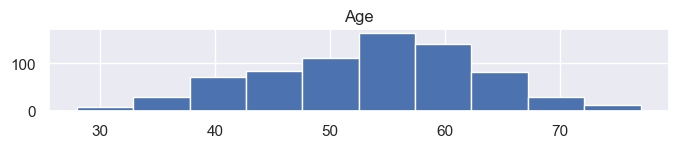

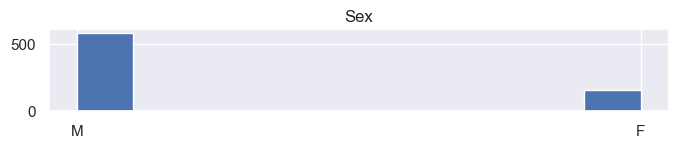

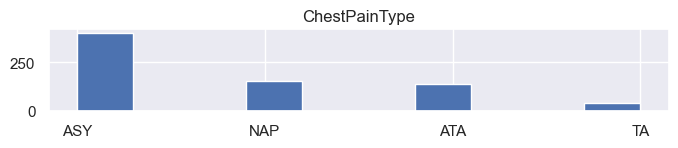

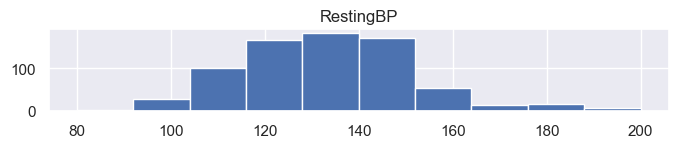

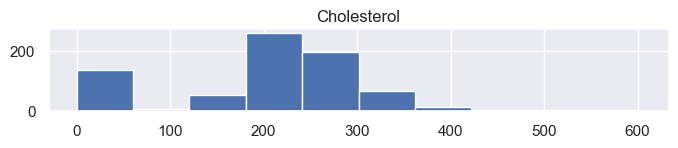

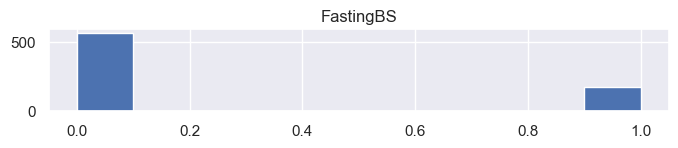

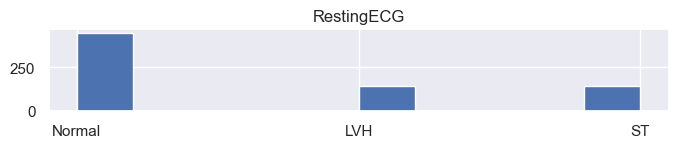

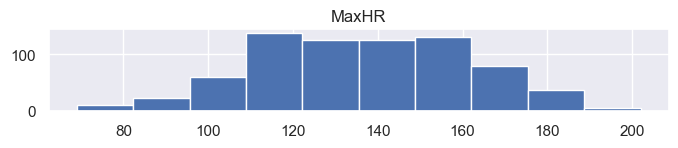

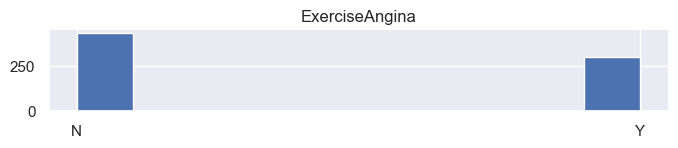

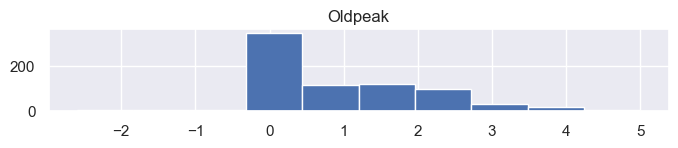

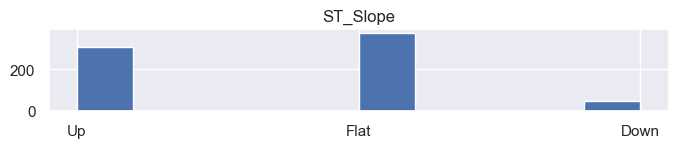

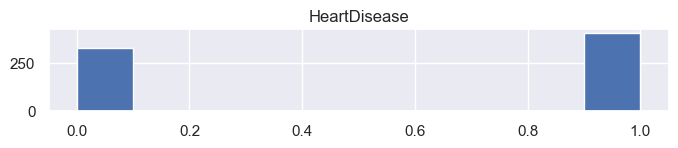

In [590]:
lis = TrainData.columns.tolist()
l =  len(lis)
for v in range(l):
    plt.figure(figsize=(8, 15))
    plt.subplot(l,1,v+1)
    plt.title(lis[v])
    plt.hist(TrainData[lis[v]])
    

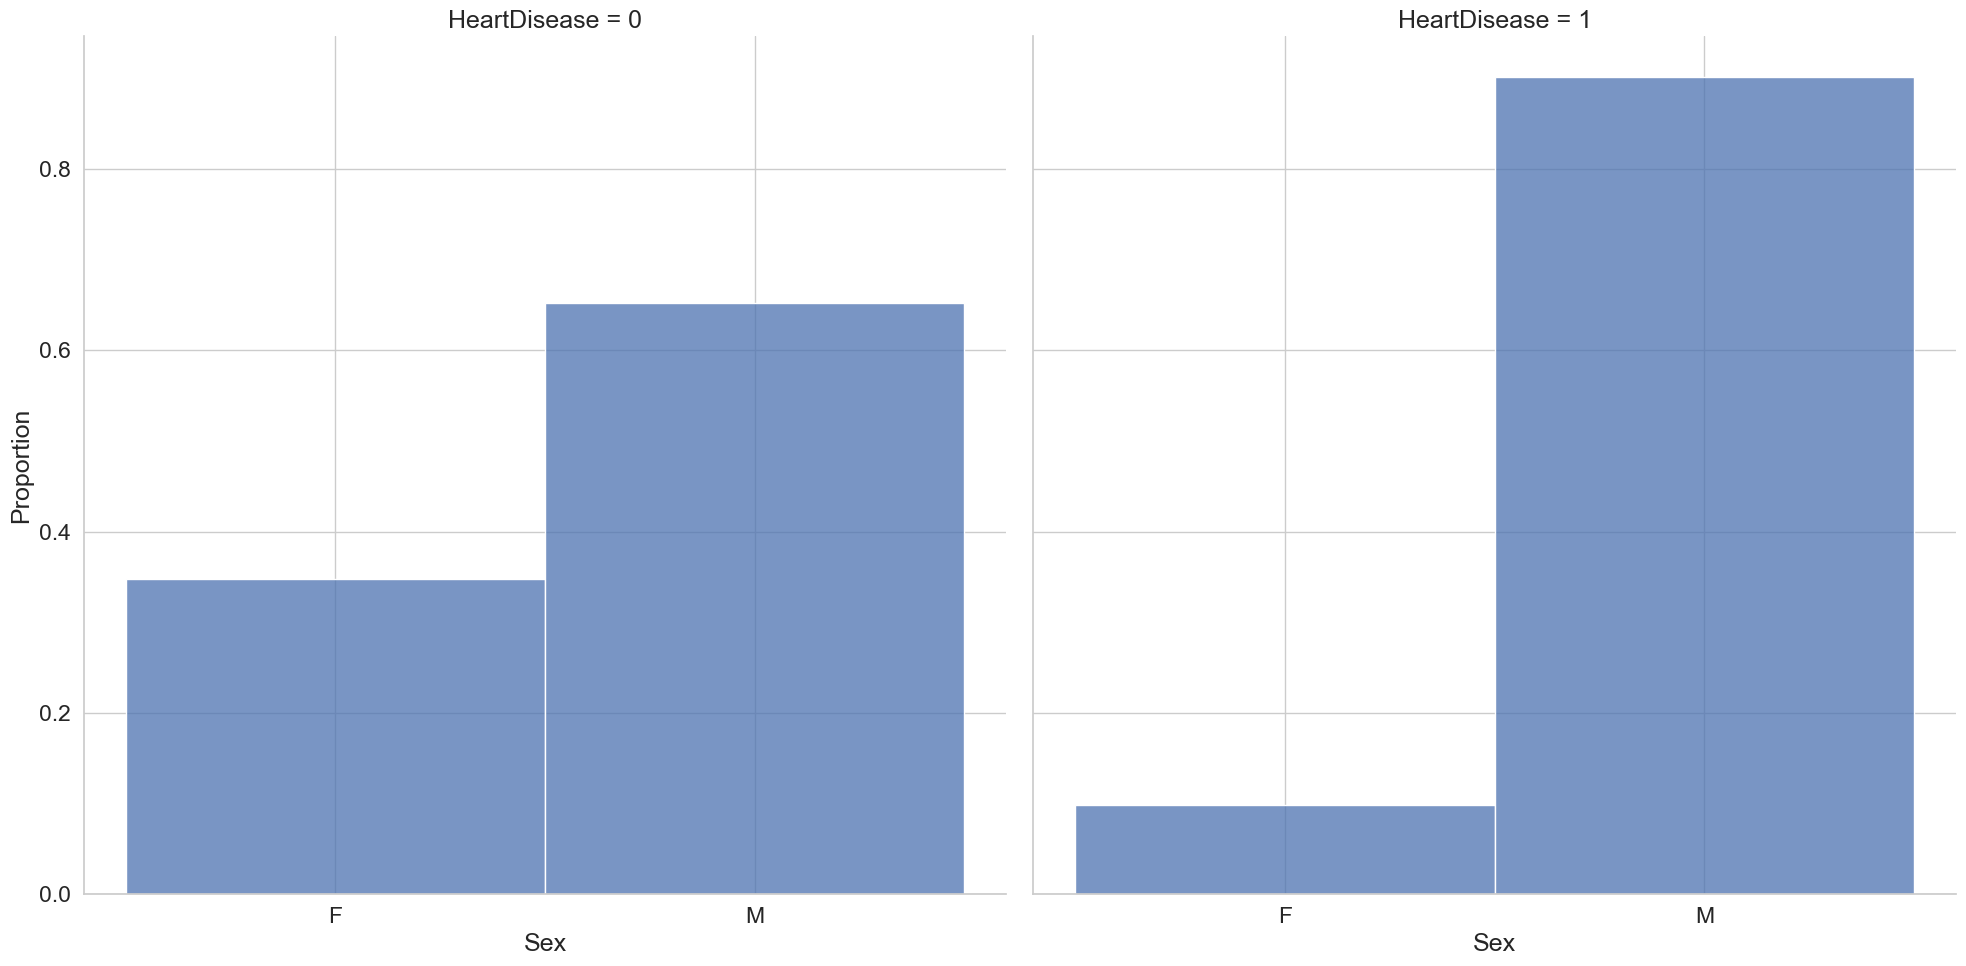

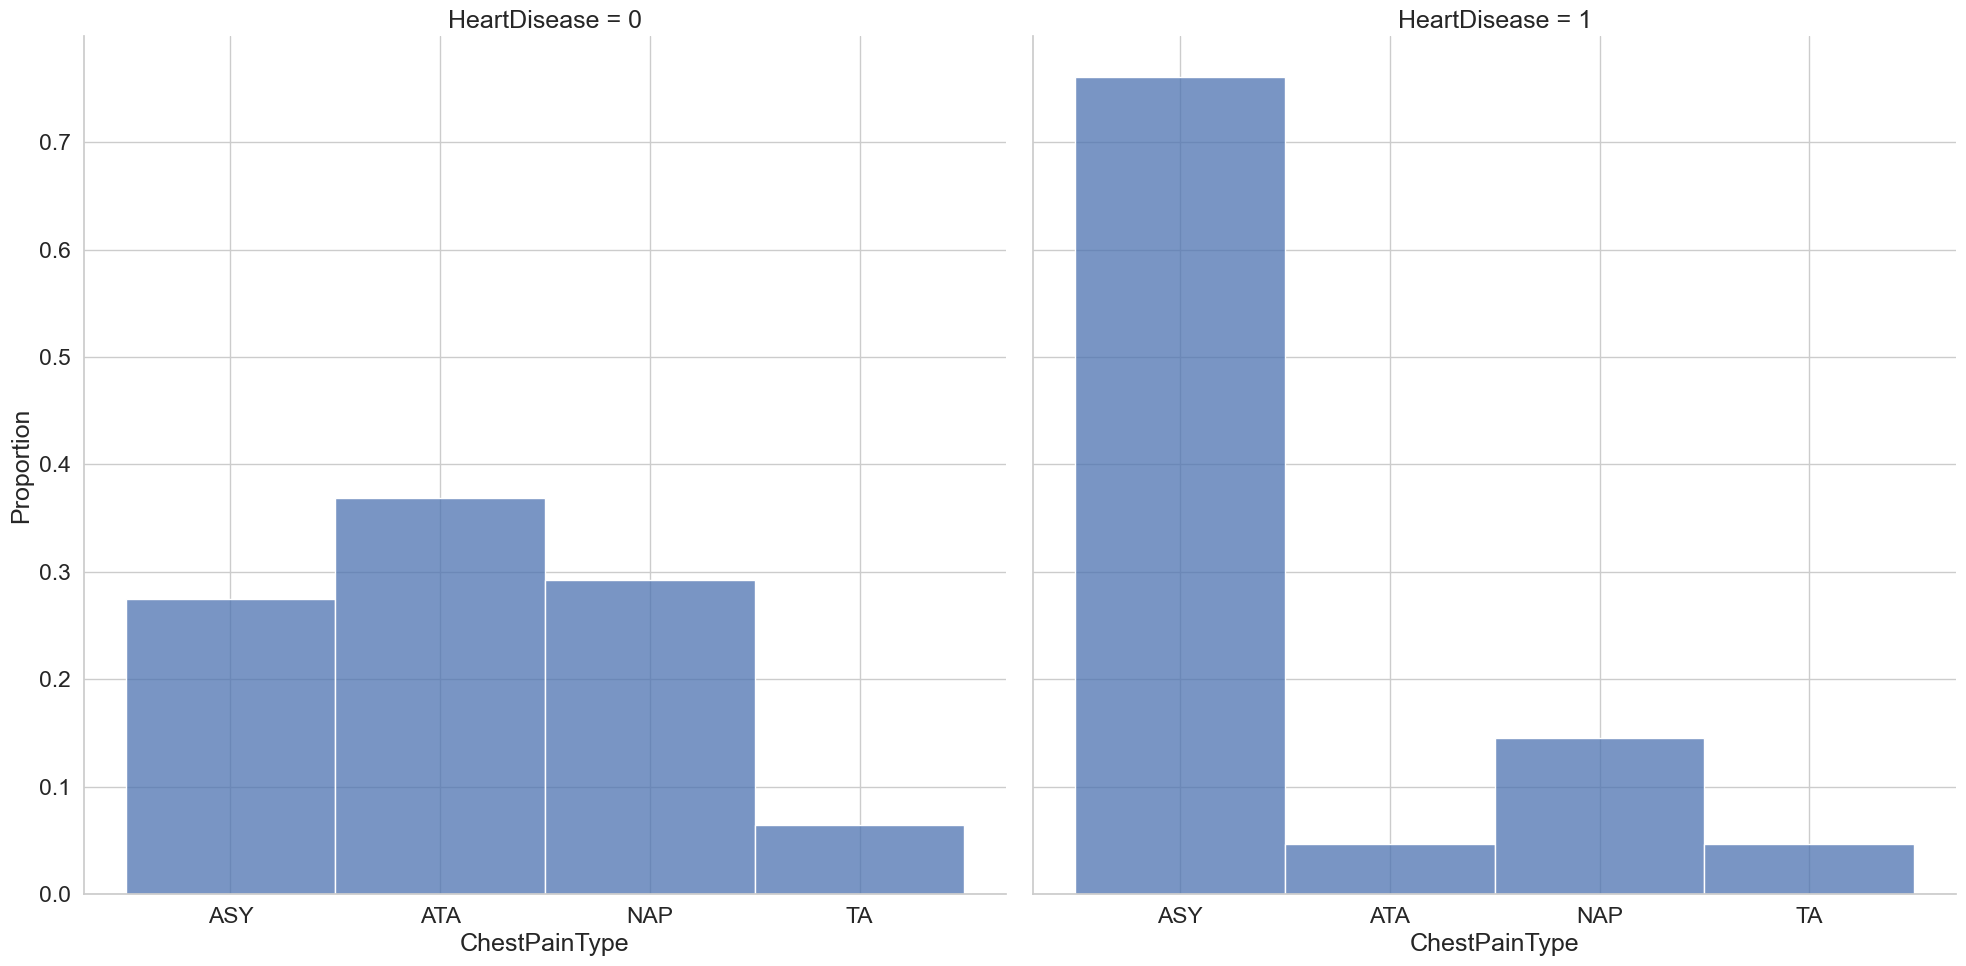

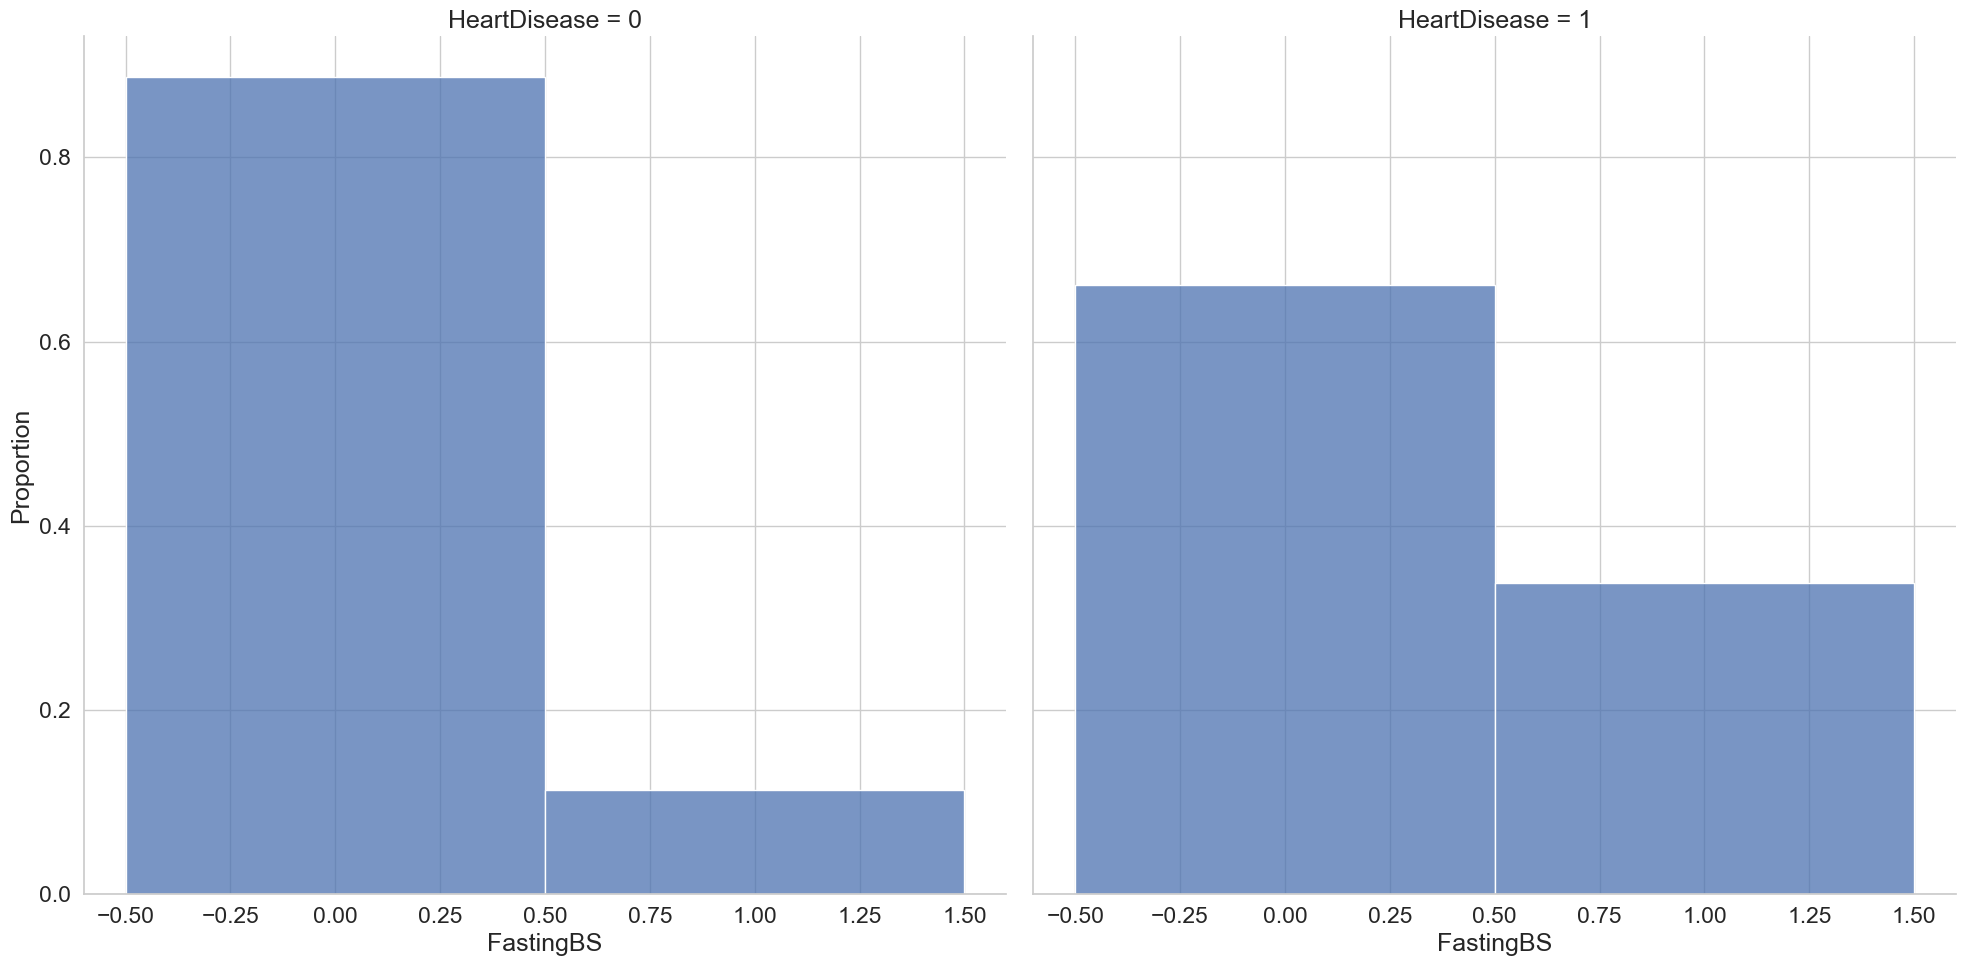

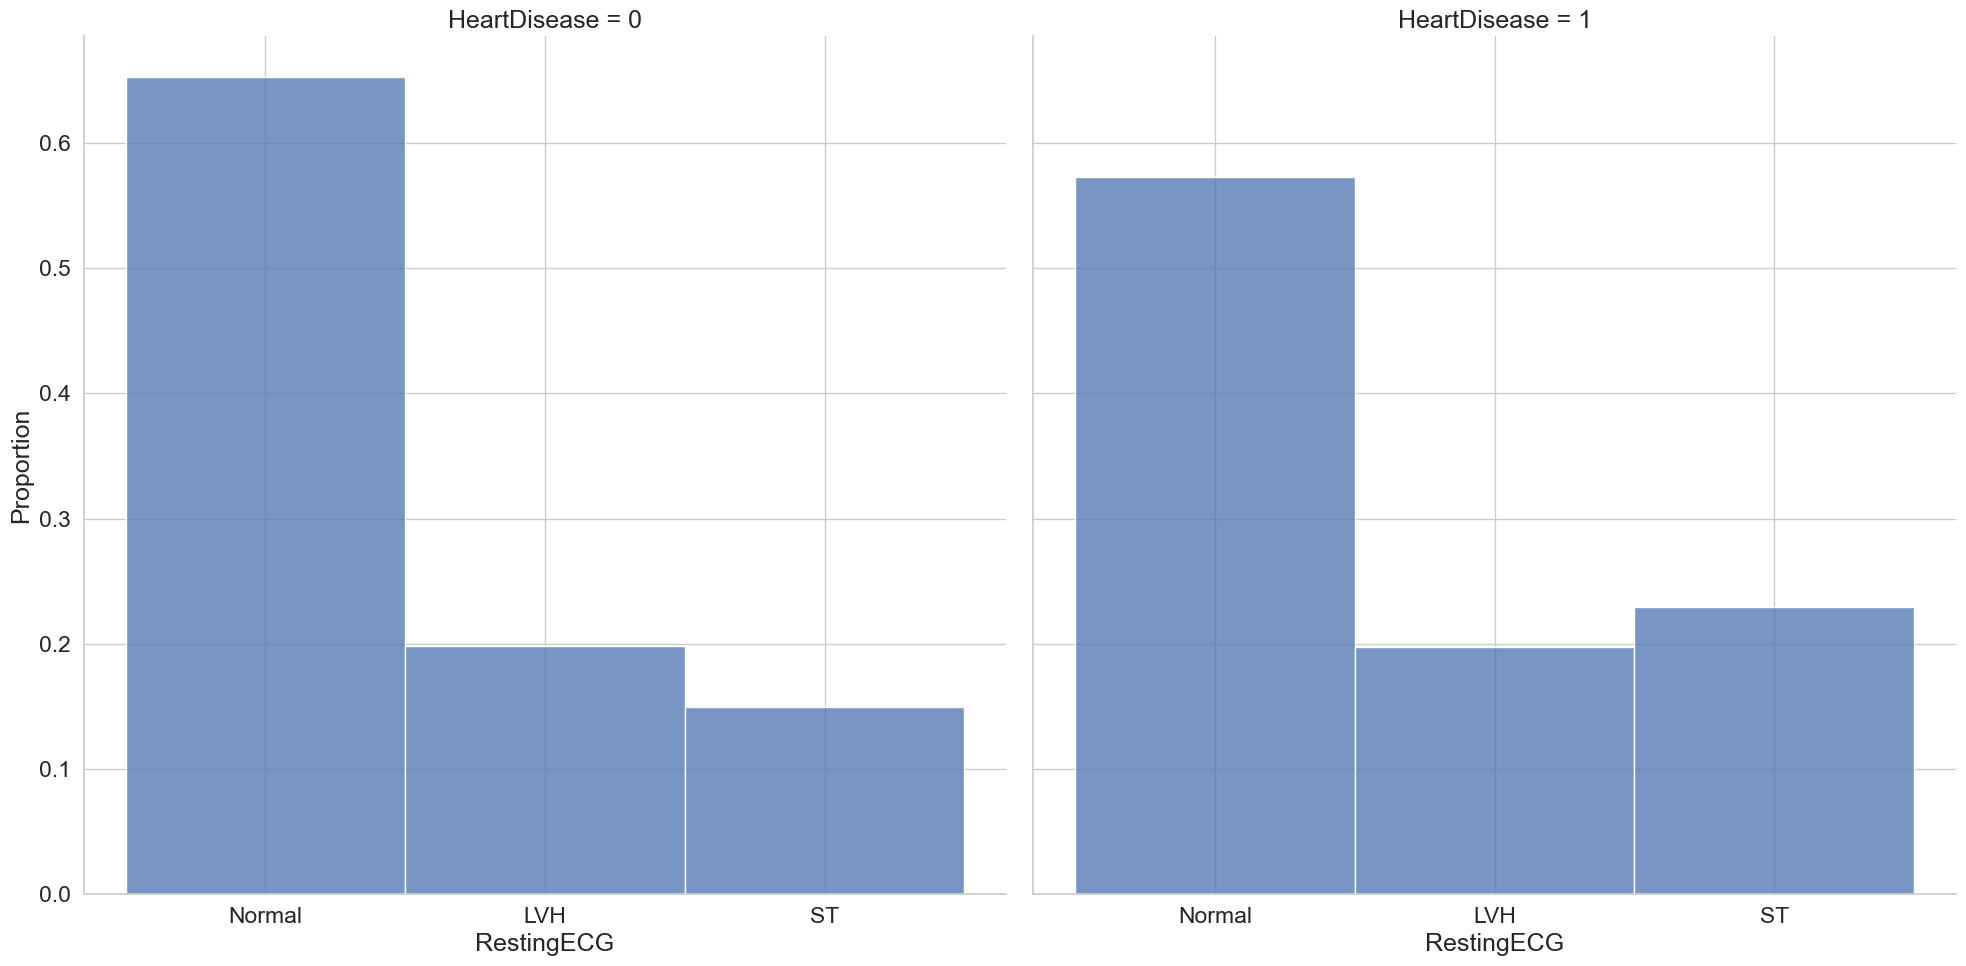

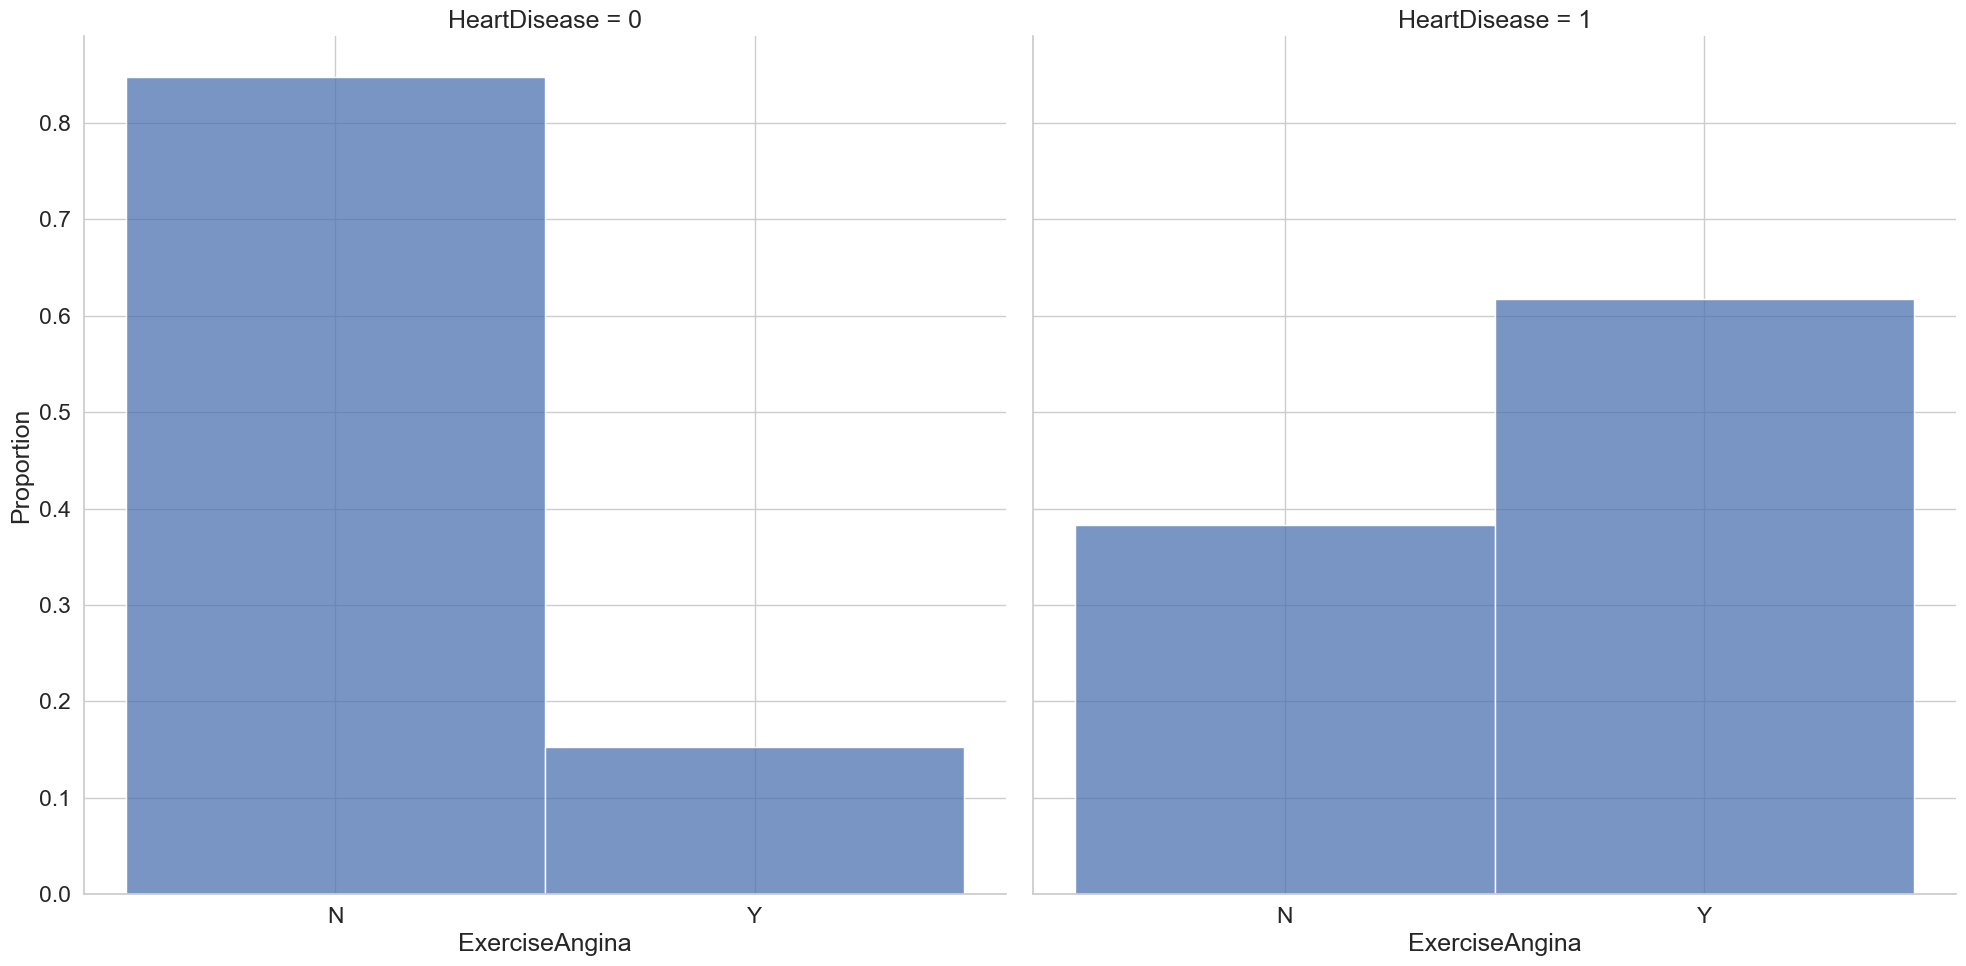

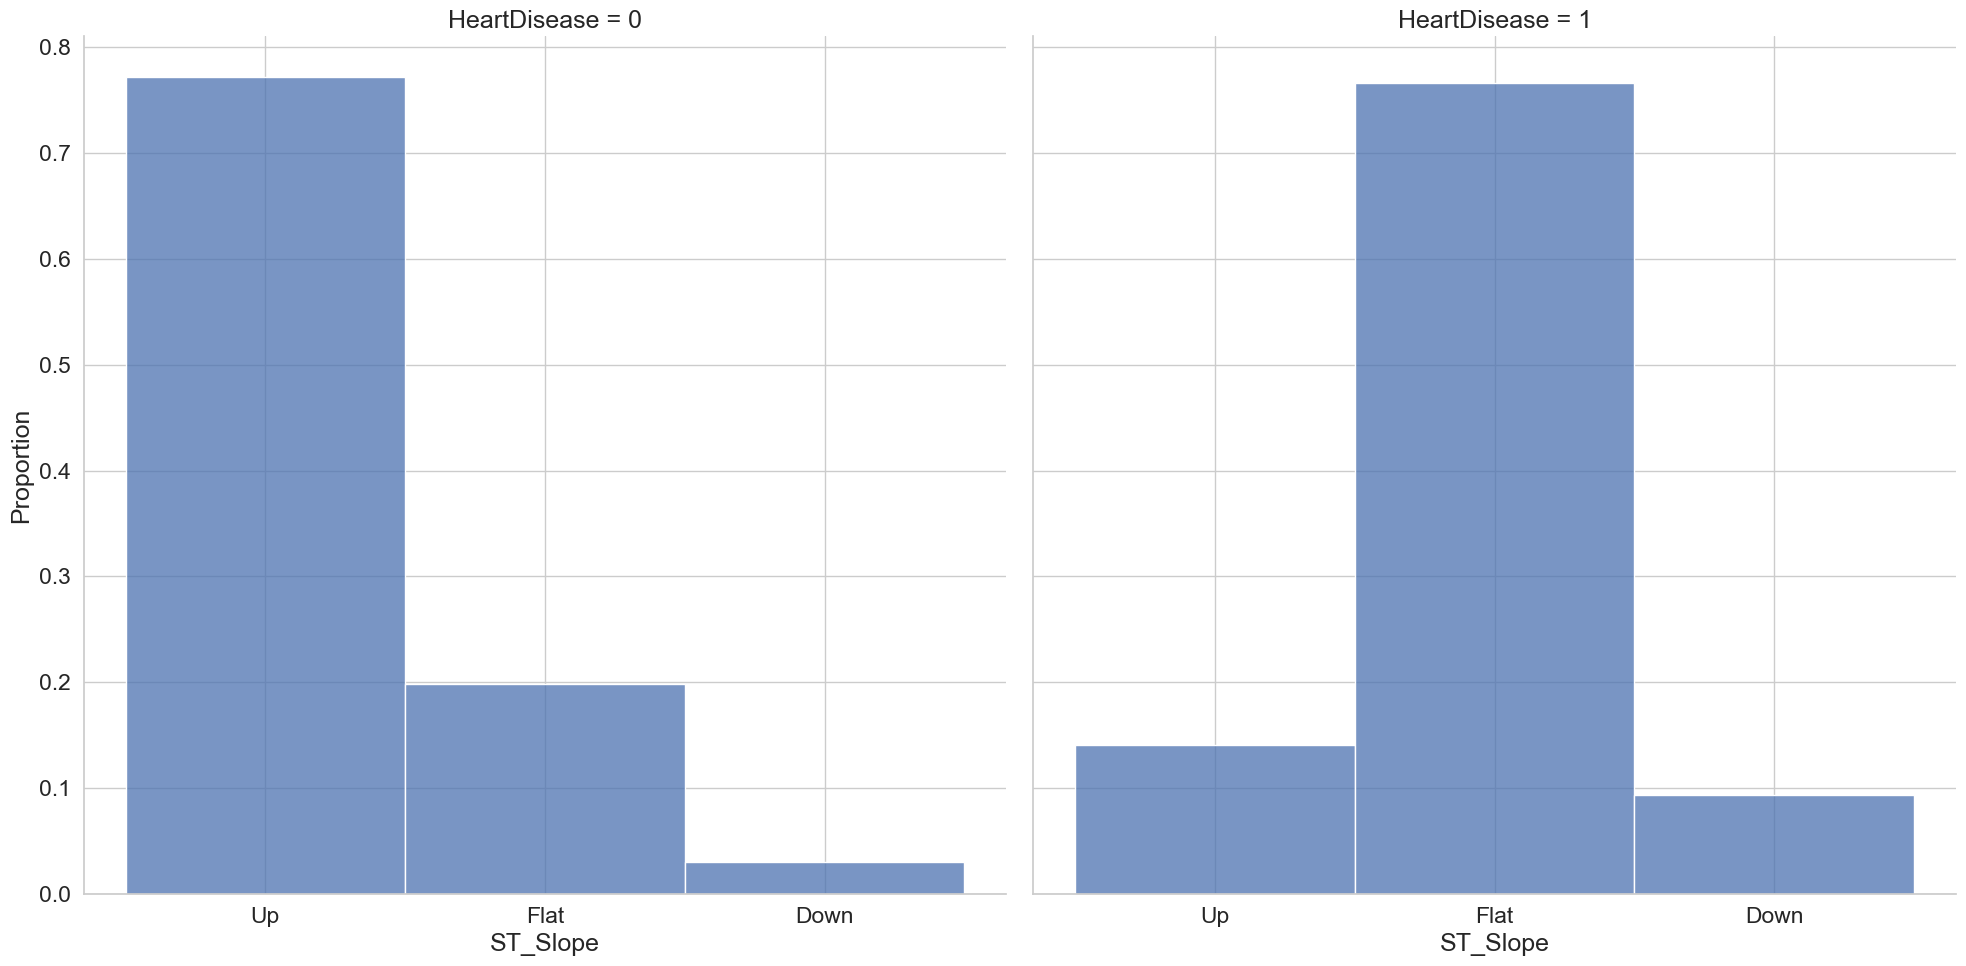

In [591]:
TrainData = heart_raw_dropped.loc[Xtrain.index]
#sb.histplot(data=TrainData[cat[i]][ TrainData['HeartDisease'] == 0],multiple='stack')
#sb.histplot(data=TrainData[cat[i]][ TrainData['HeartDisease'] == 1],multiple='stack')
sb.set(style="whitegrid", font_scale=1.5)
for i in range(6):
    g = sb.FacetGrid(TrainData[[cat[i],'HeartDisease']], col="HeartDisease",height=10, aspect=1)
    g.map(sb.histplot, cat[i],stat='proportion')

Above shows the proportion of each variable when HeartDisease = 0 or 1 ( In other words, if there is presence of coronary heart disease), where the sum of all bars in the histgram is normalized to 0, to show the proportion of each categories.

- Sex:
  - There is a obvious unbalance in sex in this dataset, but still from proportion it suggests a higher risk of coronary heart disease in male.
- ChestPainType
  - Higher level of chestpain has a positive relationship with heart disease.
- FastingBS
  - Fasting blood sugar indicates a higher risk as well.
- RestingECG
  - Positive relation with presence of LVH and ST category.
- ExerciseAngina
  - Positive relation.
- ST_Slope
  - Most patients have Flat Slope, followed by the Down Slope. A Up Slope suggests negative relation with Heart Disease.

---

#### 1.3.2 Show relationship between Response and Numeric predictors
First let's try scatter and boxplots.

<Axes: xlabel='Age', ylabel='HeartDisease'>

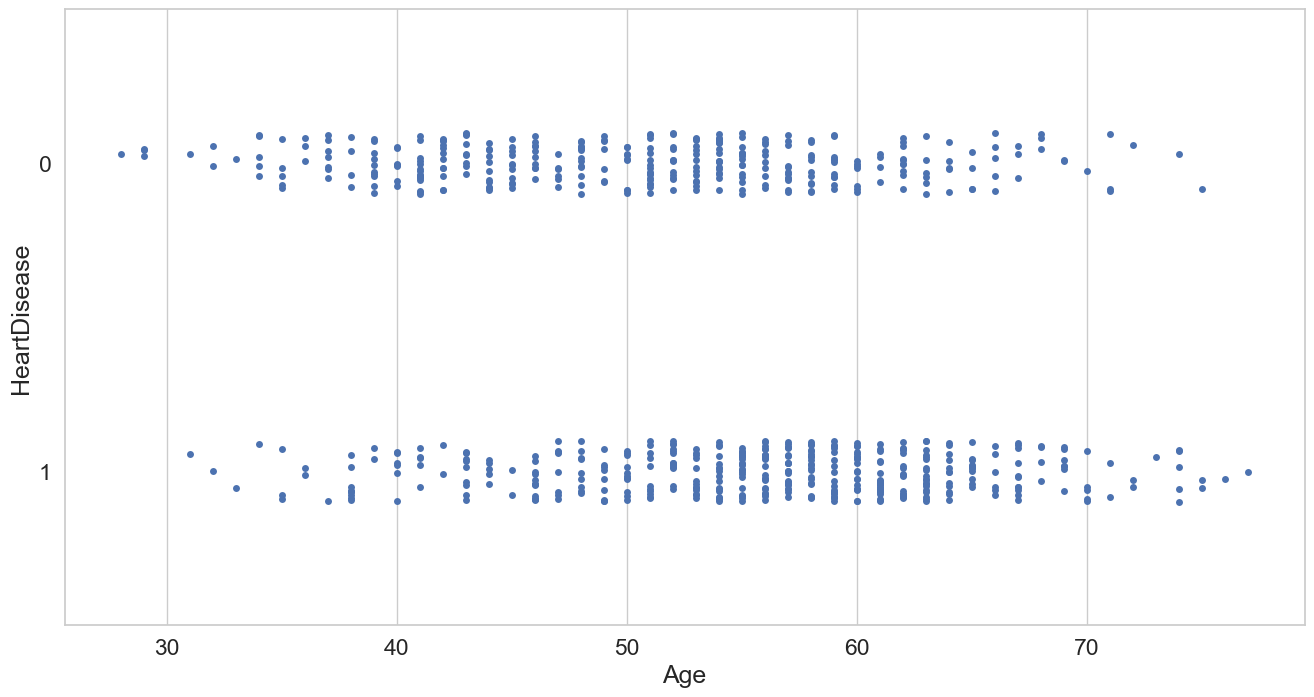

In [592]:
TrainData = heart_raw_dropped.loc[Xtrain.index]
f = plt.figure(figsize=(16, 8))
sb.stripplot(x = 'Age', y = 'HeartDisease', data = TrainData)

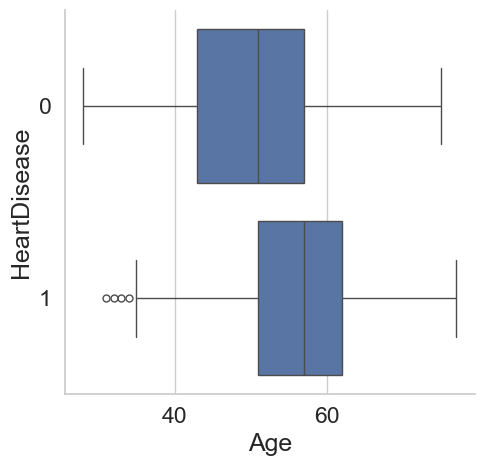

In [593]:
sb.catplot(data=TrainData, x="Age", y="HeartDisease", kind="box")

Boxplot is better when visualizing the data, so we picked boxplots for further plotting.

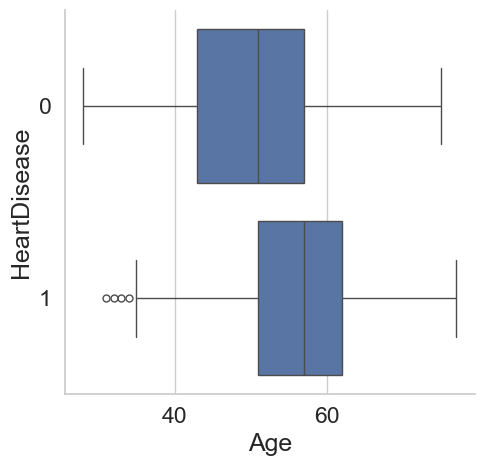

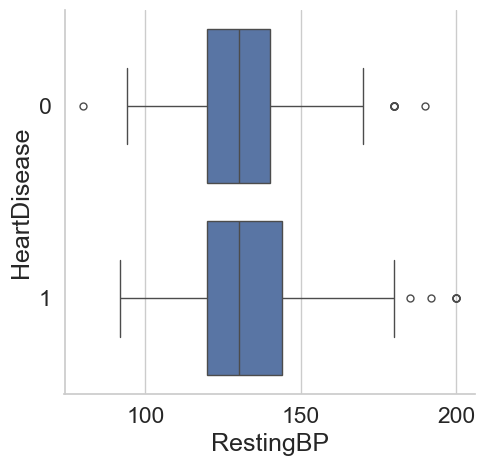

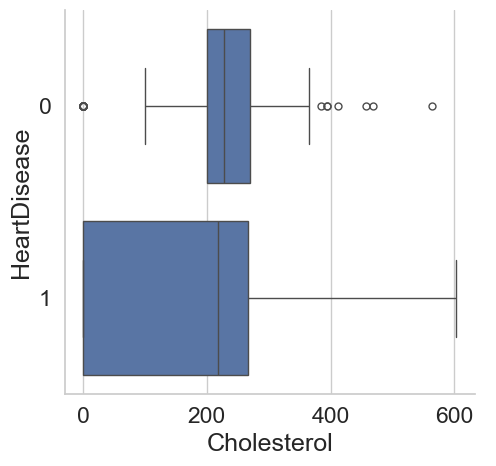

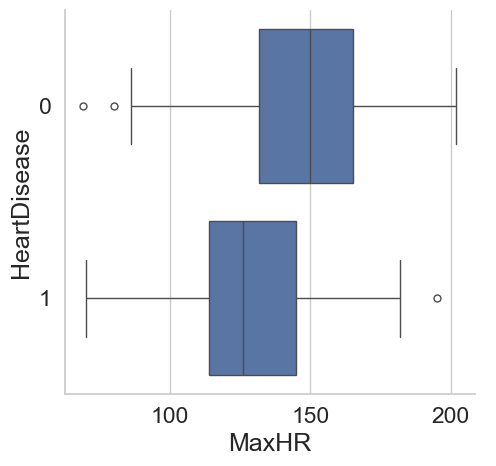

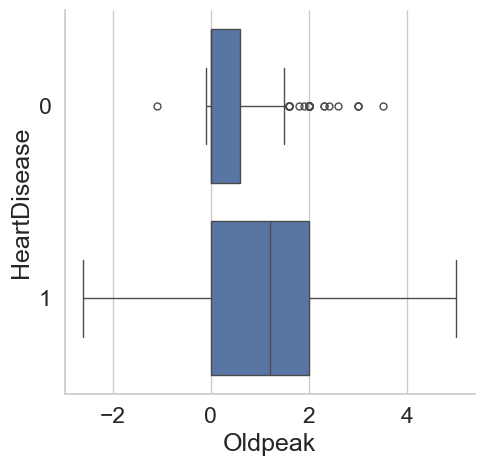

In [594]:
for i in range(5):
    sb.catplot(data=TrainData, x=numeric[i], y="HeartDisease", kind="box")
    #g = sb.FacetGrid(TrainData[[cat[i],'HeartDisease']], height=4, aspect=.5)
    #g.map(sb.stripplot,"HeartDisease",cat[i],order=['Yes','No'])

- Age
  - Overall positive relation with target. Higher Meadian and more concentrated for patients with heart disease.
- RestingBP
  - No significant difference with similar median.
- **Cholesterol**
  - Significant negative relationship, overall for positive patients, this value is **greatly skewed** and need further investigation.
- MaxHR
  - Negative relationship
- Oldpeak
  - Postive relationship. Positive cases are distributed wider, and higher median.
    > further explanation:ST depression induced by exercise relative to rest, a measure of abnormality in electrocardiograms


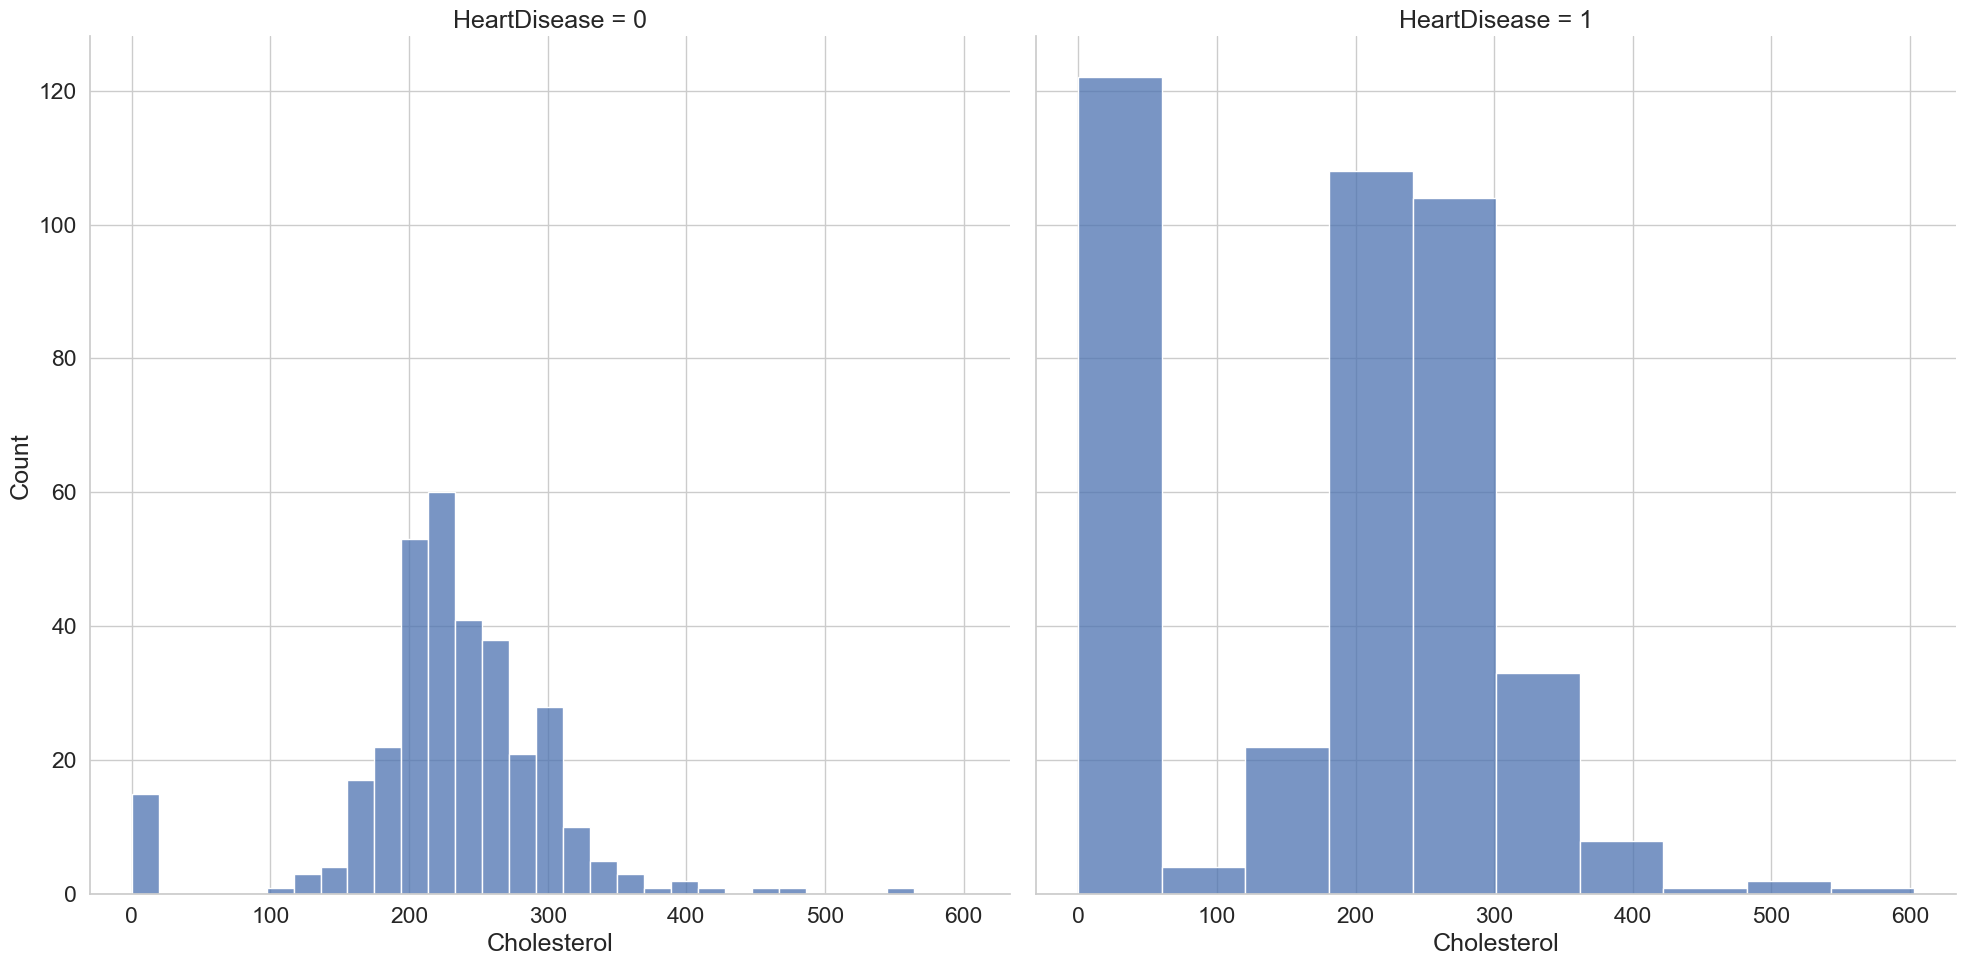

In [595]:
g = sb.FacetGrid(TrainData[['Cholesterol','HeartDisease']], col="HeartDisease",height=10, aspect=1)
g.map(sb.histplot, 'Cholesterol')

In [596]:
TrainData['Cholesterol'][TrainData['Cholesterol'] < 100].value_counts()

Cholesterol
0    137
Name: count, dtype: int64

**There are 137 entries with Cholesterol = 0 which is impossible so they should be missing values.**
A great proportion of entries with HeartDisease = 1 have Cholesterol = 0.


Currently it reflects a negative correlation with HeartDisease, but from medical knowledge it should be positive. Will test the correlation based on different imputer used.

#### 1.3.2.2 Test on Cholesterol

In [597]:
chole = TrainData[['Cholesterol','HeartDisease']]
chole = chole.astype({'HeartDisease':'int64'})
# Drop the entries.
data_drop = chole.drop(chole[chole['Cholesterol'] == 0].index)
print('Correlation After Dropping all 0s:')
print(data_drop.corr())
print()

# Filled with Median
medianImp = SimpleImputer(missing_values=0, strategy='median')
data_median = chole
data_median = data_median.reset_index()
target = pd.DataFrame(data_median['HeartDisease'])
data_median = medianImp.fit_transform(X=pd.DataFrame(data_median['Cholesterol']))
data_median = pd.concat([pd.DataFrame(data_median),target],axis=1)
print('Correlation After Filling with median:')
print(data_median.corr())

# Filled with Mean
meanImp = SimpleImputer(missing_values=0, strategy='mean')
data_median = chole
data_median = data_median.reset_index()
target = pd.DataFrame(data_median['HeartDisease'])
data_median = meanImp.fit_transform(X=pd.DataFrame(data_median['Cholesterol']))
data_median = pd.concat([pd.DataFrame(data_median),target],axis=1)
print('Correlation After Filling with mean:')
print(data_median.corr())

Correlation After Dropping all 0s:
              Cholesterol  HeartDisease
Cholesterol      1.000000      0.089356
HeartDisease     0.089356      1.000000

Correlation After Filling with median:
                     0  HeartDisease
0             1.000000      0.059658
HeartDisease  0.059658      1.000000
Correlation After Filling with mean:
                     0  HeartDisease
0             1.000000      0.080919
HeartDisease  0.080919      1.000000


**Results**:

As Filled with mean will boost its corrleation with HeartDisease, along with its weak correlation after dropping all 0 rows (Caused by most of the 0 rows have HeartDisease =1 I think), **I suggest not using cholesterol as a predictor.**

EDA Process finished.

---

## 2 Data Cleaning and Preprocessing
---
### 2.1 Imputing


Cholesterol should not use as a predictor, thus, no imputing will be done.No NAs in other predictors, only one 0 values, can be dropped.


---

### 2.2 Encoding Categorical Variables

> - #Sex: sex of the patient [M: Male, F: Female]
> - #ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
> - #FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
> - #RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation >    or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
> - #ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
> - #ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
> - #HeartDisease: output class [1: heart disease, 0: Normal]

- #Sex: Should be one-hot encoded
- #ChestPainType: Can be ordinal encoded.
- #FastingBS: Can be ordinal encoded.
- #RestingECG: Should be one-hot encoded
- #ExerciseAngina: Can be ordinal encoded.
- #ST_Slope: Should be one-hot encoded
- #HeartDisease: output class

**We will do transform later in pipelines**

### 2.3 Drop Outliers Row

As quantity of outliers is not so big, we can simply drop the rows they are in.

**\*`Cholesterol` will be dropped\***

---

First let's check numbers of outliers

In [598]:
TrainData = TrainData.drop('Cholesterol',axis=1)
TrainData

,Age,Sex,ChestPainType,RestingBP,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
655,40,M,ASY,152,0,Normal,181,N,0.0,Up,1
428,62,M,ASY,110,0,Normal,120,Y,0.5,Flat,1
103,40,M,ASY,120,1,Normal,152,Y,1.0,Flat,1
8,37,M,ASY,140,0,Normal,130,Y,1.5,Flat,1
717,49,F,ASY,130,0,Normal,163,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...
622,59,M,ASY,110,0,LVH,142,Y,1.2,Flat,1
586,53,M,ASY,124,0,Normal,122,Y,2.0,Flat,1
734,56,M,ASY,130,1,LVH,103,Y,1.6,Down,1
281,49,M,ASY,150,0,Normal,122,N,2.0,Flat,1


In [599]:
numeric = ['Age','RestingBP','MaxHR','Oldpeak']
for v in numeric:
    q1 = TrainData[v].quantile(0.25)
    q3 = TrainData[v].quantile(0.75)
    IQR = q3 - q1
    count = len(TrainData[v].loc[ (TrainData[v] < q1 - 1.5* IQR) | (TrainData[v] > q3 + 1.5* IQR) ])
    print(f"{v} : {count}")

Age : 0
RestingBP : 22
MaxHR : 0
Oldpeak : 11


In [600]:
numeric = ['Age','RestingBP','MaxHR','Oldpeak']
for v in numeric:
    q1 = TrainData[v].quantile(0.25)
    q3 = TrainData[v].quantile(0.75)
    IQR = q3 - q1
    TrainData = TrainData[ (TrainData[v] > q1 - 1.5* IQR) & (TrainData[v] < q3 + 1.5* IQR) ] # Filtered Data

TrainData

,Age,Sex,ChestPainType,RestingBP,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
655,40,M,ASY,152,0,Normal,181,N,0.0,Up,1
428,62,M,ASY,110,0,Normal,120,Y,0.5,Flat,1
103,40,M,ASY,120,1,Normal,152,Y,1.0,Flat,1
8,37,M,ASY,140,0,Normal,130,Y,1.5,Flat,1
717,49,F,ASY,130,0,Normal,163,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...
622,59,M,ASY,110,0,LVH,142,Y,1.2,Flat,1
586,53,M,ASY,124,0,Normal,122,Y,2.0,Flat,1
734,56,M,ASY,130,1,LVH,103,Y,1.6,Down,1
281,49,M,ASY,150,0,Normal,122,N,2.0,Flat,1


### 2.4 Scaling Numeric Variables


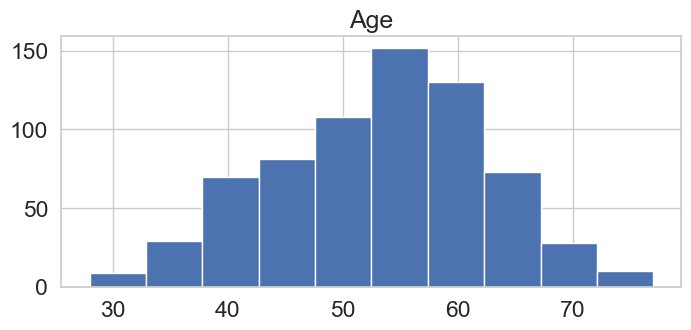

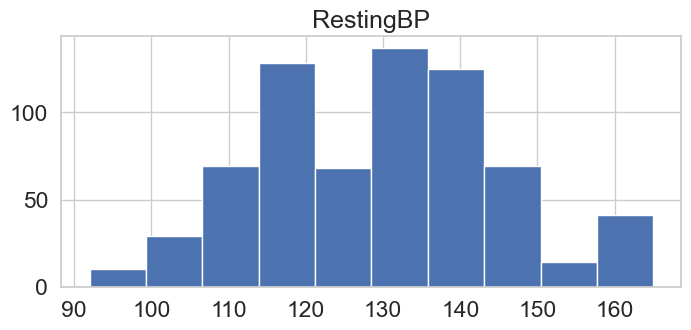

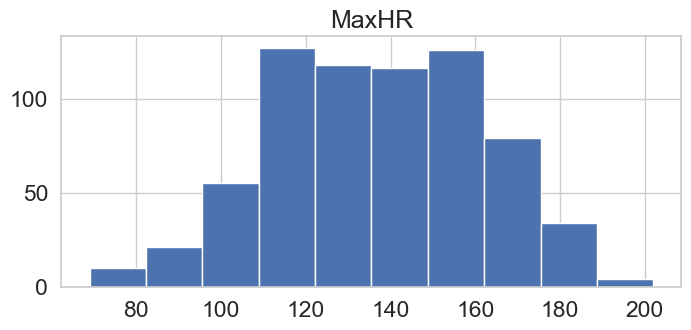

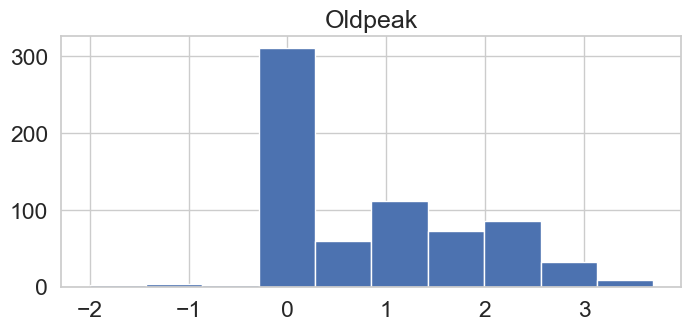

In [602]:
for v in range(4):
    plt.figure(figsize=(8, 15))
    plt.subplot(4,1,v+1)
    plt.title(numeric[v])
    plt.hist(TrainData[numeric[v]])

Distribution of Age, RestingBP, MaxHR are close to standard distributions and can be scaled by standardization.
However Oldpeak has a heavy tail. Besides it has negative values.

In [603]:
cat = ['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope']
Cat_OneHot = ['Sex','RestingECG','ST_Slope']
Cat_Ordinal = ['ChestPainType','FastingBS','ExerciseAngina']
numeric = ['Age','RestingBP','MaxHR','Oldpeak']
Num_Standardize = ['Age','RestingBP','MaxHR']  # Cholesterol is dropped from here on
Num_HeavyTail = ['Oldpeak']

---

Here is experiment on oldpeak

(array([  1.,   1.,   1.,   3.,   1.,   0., 311.,  35.,  25.,  72.,  40.,
         56.,  82.,  10.,  17.,  25.,   2.,   7.,   1.]),
 array([-2.        , -1.68421053, -1.36842105, -1.05263158, -0.73684211,
        -0.42105263, -0.10526316,  0.21052632,  0.52631579,  0.84210526,
         1.15789474,  1.47368421,  1.78947368,  2.10526316,  2.42105263,
         2.73684211,  3.05263158,  3.36842105,  3.68421053,  4.        ]),
 <BarContainer object of 19 artists>)

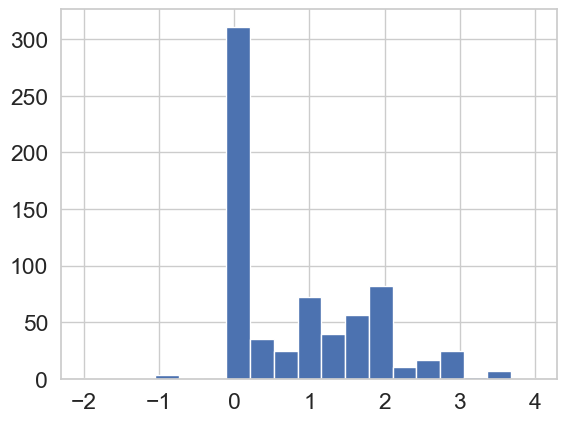

In [604]:
heavy = TrainData[Num_HeavyTail]
plt.hist(heavy,bins= np.linspace(-2,4,20))

(array([282.,   0.,   0.,  13.,  26.,  35.,  86.,  96., 109.,  35.]),
 array([-1.13377528, -0.86646704, -0.5991588 , -0.33185057, -0.06454233,
         0.20276591,  0.47007414,  0.73738238,  1.00469062,  1.27199885,
         1.53930709]),
 <BarContainer object of 10 artists>)

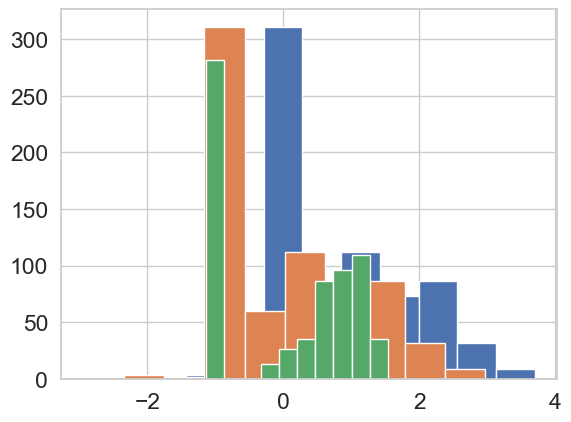

In [605]:
heavy = TrainData[Num_HeavyTail]
ss = StandardScaler()

plt.hist(heavy)
plt.hist(ss.fit_transform(heavy))
plt.hist(ss.fit_transform(heavy**0.3))

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0., 282.,
          0.,  13.,   0.,  15.,   0.,  11.,   0.,  10.]),
 array([-0.5       , -0.45263158, -0.40526316, -0.35789474, -0.31052632,
        -0.26315789, -0.21578947, -0.16842105, -0.12105263, -0.07368421,
        -0.02631579,  0.02105263,  0.06842105,  0.11578947,  0.16315789,
         0.21052632,  0.25789474,  0.30526316,  0.35263158,  0.4       ]),
 <BarContainer object of 19 artists>)

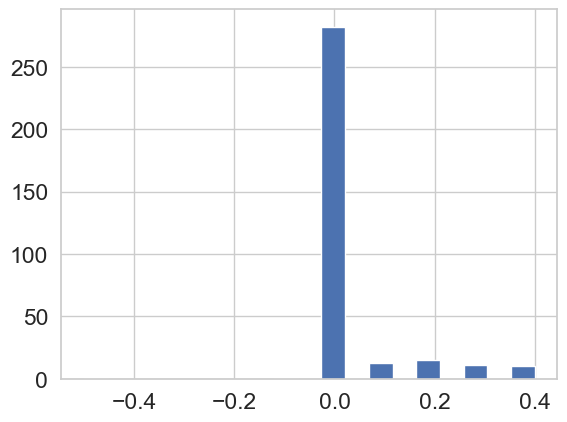

In [606]:
heavy = pd.DataFrame(TrainData[Num_HeavyTail])
center = heavy[ (heavy['Oldpeak'] < 0.4) | (heavy['Oldpeak'] > -0.5) ]
plt.hist(center,bins= np.linspace(-0.5,0.4,20))

**Conclusion: Most values are centralized at 0. Maybe no need to scale.**

In [607]:
transform_pipe = ColumnTransformer([
    ('num_standard',StandardScaler(),Num_Standardize),
    ('cat_onehot',OneHotEncoder(handle_unknown="ignore"),Cat_OneHot),
    ('cat_ordinal',OrdinalEncoder(),Cat_Ordinal)],remainder="passthrough")

#### Process and Write Data

In [609]:
heart_test = heart_raw_dropped.loc[Xtest.index]
TrainData.to_csv('train_raw.csv')
heart_test.to_csv('test_raw.csv')


In [610]:

heart_train_processed = pd.DataFrame(transform_pipe.fit_transform(TrainData))
heart_train_processed.columns = transform_pipe.get_feature_names_out()
heart_train_processed

,num_standard__Age,num_standard__RestingBP,num_standard__MaxHR,cat_onehot__Sex_F,cat_onehot__Sex_M,cat_onehot__RestingECG_LVH,cat_onehot__RestingECG_Normal,cat_onehot__RestingECG_ST,cat_onehot__ST_Slope_Down,cat_onehot__ST_Slope_Flat,cat_onehot__ST_Slope_Up,cat_ordinal__ChestPainType,cat_ordinal__FastingBS,cat_ordinal__ExerciseAngina,remainder__Oldpeak,remainder__HeartDisease
0,-1.400339,1.455454,1.757204,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.921324,-1.306583,-0.676835,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.5,1.0
2,-1.400339,-0.648955,0.600038,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
3,-1.716929,0.666301,-0.277812,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.5,1.0
4,-0.450568,0.008673,1.038963,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,0.604733,-1.306583,0.201015,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.2,1.0
686,-0.028447,-0.385904,-0.597031,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0
687,0.288143,0.008673,-1.355174,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.6,1.0
688,-0.450568,1.323929,-0.597031,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0


In [611]:
heart_test_processed = pd.DataFrame(transform_pipe.transform(heart_test)) 
# When pipeline is trained on train set, it should not fit test set.
# Just transform.
heart_test_processed.columns = transform_pipe.get_feature_names_out()
heart_test_processed

,num_standard__Age,num_standard__RestingBP,num_standard__MaxHR,cat_onehot__Sex_F,cat_onehot__Sex_M,cat_onehot__RestingECG_LVH,cat_onehot__RestingECG_Normal,cat_onehot__RestingECG_ST,cat_onehot__ST_Slope_Down,cat_onehot__ST_Slope_Flat,cat_onehot__ST_Slope_Up,cat_ordinal__ChestPainType,cat_ordinal__FastingBS,cat_ordinal__ExerciseAngina,remainder__Oldpeak,remainder__HeartDisease
0,0.815794,0.797827,-1.474880,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,1.0,0.0,1.5,1.0
1,2.504275,-0.385904,-1.075858,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0
2,1.554504,0.337487,-0.676835,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,1.660034,0.337487,-0.277812,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.660034,-0.517429,-2.113317,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,-0.133977,1.981557,-2.193121,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,4.0,1.0
180,1.765564,0.995115,-0.477324,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.6,1.0
181,0.077083,-0.320141,0.600038,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.5,0.0
182,0.288143,-0.648955,0.520233,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0


In [612]:
heart_train_processed.to_csv('train_processed.csv')
heart_test_processed.to_csv('test_processed.csv')
